In [1]:
import torch
import numpy as np
import pandas as pd

**Building input pipelines in PyTorch:**
- In typical use cases, however, when the dataset is too large to fit into computer memory, we need to load the data from the main storage device in chunks, i.e. batch by batch. 
- In addition, we may need to construct a data-preprocessing pipeline to apply certain transformations and preprocessing steps to our data 
- Applying preprocessing functions manually every time can be quite cumbersome. Luckily, PyTorch provides a special class for constructing efficient and convenient preprocessing pipelines. 
- In this section - overview of different methods for constructing a PyTorch Dataset and DataLoader, and implementing data loading, shuffling, and batching.

**Creating a PyTorch DataLoader from existing tensors:**

If the data exists in form of a tensor object, a Python list, or a Numpy array, we can easily create a dataset loader using the torch.utils.data.DataLoader() class. It returns an object of the DataLoader class, which we can use to iterate through the individual elements in the input dataset.

In [2]:
from torch.utils.data import DataLoader

In [3]:
t = torch.arange(6, dtype=torch.float32)

In [4]:
data_loader = DataLoader(t)

We can then easily iterate through a dataset entry as follows:

In [5]:
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


If, we want to create batches, say with a desired batch size of 3, we can do this with the batch size argument as follows:

In [6]:
data_loader = DataLoader(t, batch_size=3, drop_last=False)
for i, batch in enumerate(data_loader,1):
    print(f'batch {i}:',batch)

batch 1: tensor([0., 1., 2.])
batch 2: tensor([3., 4., 5.])


**Combining two tensors into a joint dataset:**
Often, we may have the data in two (or possibly more) tensors - e.g. a tensor for features, and a tensor for labels. In such cases, we need to build a dataset that combines these tensors, which will allows us to retrieve the elements of these tensors in tuples.
Assume - two tensors: t_x, and t_y. Tensor t_x holds our feature values, each of size 3, and t_y stores the class labels. 

In [7]:
torch.manual_seed(1)
t_x = torch.rand([4,3], dtype=torch.float32)
t_y = torch.arange(4)

Now, we want to create a joint dataset from these two tensors. First, we need to create a Dataset class as follows:

In [8]:
from torch.utils.data import Dataset

In [12]:
class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]

A custom Dataset class must contain the following methods to be used by the dataloader later on:
- __init__(): This is where the initial logic happens, such as reading existing arrays, loading a file, filtering data, and so forth
- __getitem__(): This returns the corresponding sample to the given index
Then, we create a joint dataset of t_x and t_y with a custom dataset as follows:

Can either use the custom dataset class defined above, especially if you wanted to add some extra logic such as transformations. But, if the main use case is just to return a tuple that contains both tensors then you can use pytorch's TensorDataset function as well:

In [13]:
from torch.utils.data import TensorDataset

In [14]:
joint_dataset = TensorDataset(t_x, t_y)

In [16]:
for example in joint_dataset:
    print(' x:',example[0], ' y:',example[1])

 x: tensor([0.7576, 0.2793, 0.4031])  y: tensor(0)
 x: tensor([0.7347, 0.0293, 0.7999])  y: tensor(1)
 x: tensor([0.3971, 0.7544, 0.5695])  y: tensor(2)
 x: tensor([0.4388, 0.6387, 0.5247])  y: tensor(3)


**shuffle, batch, and repeat:**

When training a NN model using stochastic gradient descent optimization, it is important to feed training data as randomly shuffled batches. 

First, let's create a shuffled version data loader from the joint_dataset dataset:

In [17]:
torch.manual_seed(1)
data_loader = DataLoader(dataset = joint_dataset, batch_size=2, shuffle=True)

Here, each batch contains two data records (x), and the corresponding labels (y). Now, we iterate through the data loader entry by entry as follows:

In [18]:
for i,batch in enumerate(data_loader,1):
    print(f'batch {i}',batch)

batch 1 [tensor([[0.3971, 0.7544, 0.5695],
        [0.7576, 0.2793, 0.4031]]), tensor([2, 0])]
batch 2 [tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]), tensor([1, 3])]


In [19]:
for i,batch in enumerate(data_loader,1):
    print(f'batch {i}: ', 'x:',batch[0],
          '\n              y:',batch[1])

batch 1:  x: tensor([[0.7576, 0.2793, 0.4031],
        [0.3971, 0.7544, 0.5695]]) 
              y: tensor([0, 2])
batch 2:  x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]) 
              y: tensor([1, 3])


The rows are shuffled without losing one-to-one correspondence between the entries in x and y.
In addition, when training a model for multiple epochs, we need to shuffle and iterate over the dataset by the desired number of epochs. So, let's iterate over the batched dataset twice (2 epochs):

In [20]:
for epoch in range(2):
    print(f'epoch {epoch+1}')
    for i,batch in enumerate(data_loader,1):
        print(f'batch {i}:','x:',batch[0],
                '\n  y:',batch[1])

epoch 1
batch 1: x: tensor([[0.4388, 0.6387, 0.5247],
        [0.3971, 0.7544, 0.5695]]) 
  y: tensor([3, 2])
batch 2: x: tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999]]) 
  y: tensor([0, 1])
epoch 2
batch 1: x: tensor([[0.7576, 0.2793, 0.4031],
        [0.4388, 0.6387, 0.5247]]) 
  y: tensor([0, 3])
batch 2: x: tensor([[0.3971, 0.7544, 0.5695],
        [0.7347, 0.0293, 0.7999]]) 
  y: tensor([2, 1])


This results in two different sets of batches. In the first epoch the first batch contains a pair of values [y=3,y=2], and the second batch contains [y=0,y=1]. In the second epoch, two batches contain a pair of values [y=0,y=3] and [y=2,y=1] respectively. For each iteration, the elements within a batch are also shuffled.

**Creating a dataset from files on your local storage disk:**
We now build a dataset from image files stored on disk. This small dataset example will show how building a dataset from stored files generally works. To accomplish this, we're going to use two additional modules: Image in PIL to read the image file contents and transforms in torchvision to decode the raw contents and resize the images.

Before we start, let's take a look at the contents of these files, we will use the pathlib library to generate a list of image files

In [21]:
rpath = r"C:\Users\blais\Documents\ML\data\cat_dog_images"

In [22]:
import pathlib
imgdir_path = pathlib.Path(rpath)

In [23]:
file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

In [24]:
print(file_list)

['C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\cat-01.jpg', 'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\cat-02.jpg', 'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\cat-03.jpg', 'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\dog-01.jpg', 'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\dog-02.jpg', 'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\dog-03.jpg']


Next, lets visualize these image examples using matplotlib:

In [25]:
import matplotlib.pyplot as plt
import os
from PIL import Image

Image shape: (900, 1200, 3)
Image shape: (900, 1200, 3)
Image shape: (900, 742, 3)
Image shape: (800, 1200, 3)
Image shape: (800, 1200, 3)
Image shape: (900, 1200, 3)


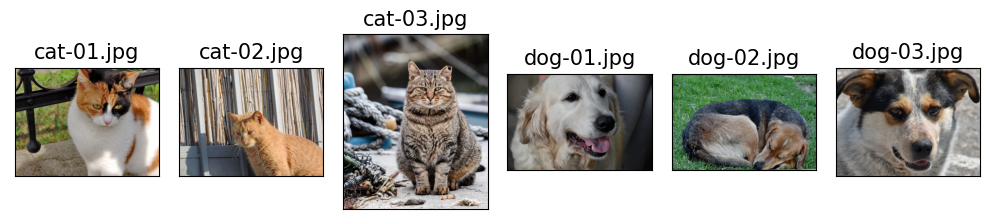

In [26]:
fig, ax = plt.subplots(1,6,figsize=(10,5))
for i,file in enumerate(file_list):
    img = Image.open(file)
    print('Image shape:',np.array(img).shape)
    ax[i].set_xticks([]); ax[i].set_yticks([]);
    ax[i].imshow(img)
    ax[i].set_title(os.path.basename(file),size=15)
plt.tight_layout()
plt.show()

In [28]:
file_list[0]

'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\cat-01.jpg'

Image shape:  (900, 1200, 3)
Image shape:  (900, 1200, 3)
Image shape:  (900, 742, 3)
Image shape:  (800, 1200, 3)
Image shape:  (800, 1200, 3)
Image shape:  (900, 1200, 3)


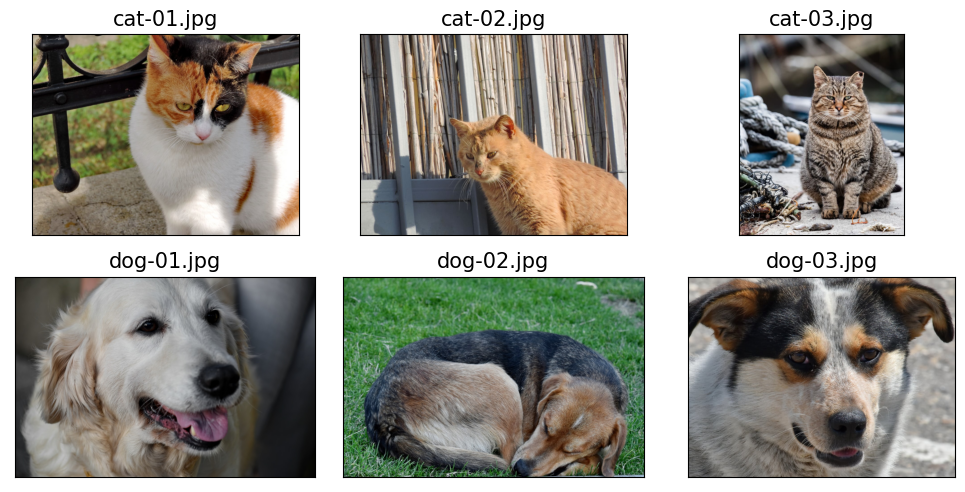

In [32]:
fig, ax = plt.subplots(2,3,figsize=(10,5))
counter = 0
for i in range(2):
    for j in range(3):
        img = Image.open(file_list[counter])
        print('Image shape: ', np.array(img).shape)
        ax[i,j].set_xticks([]);ax[i,j].set_yticks([]);
        ax[i,j].imshow(img)
        ax[i,j].set_title(os.path.basename(file_list[counter]),size=15)
        counter+=1
plt.tight_layout()
plt.show()

In [34]:
# lets create labels, assigning 1 to dogs and 0 to cats:
labels = [1 if 'dog' in os.path.basename(file) else 0 for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


Now, we have 2 lists: a list of filenames (or paths of each image) and a list of their labels. We now create a joint dataset with that:

In [35]:
class ImageDataset(Dataset):
    def __init__(self,file_list,labels):
        self.file_list = file_list
        self.labels = labels
    
    def __getitem__(self,index):
        file = self.file_list[index]
        label = self.labels[index]
        return file,label
    
    def __len__(self):
        return len(self.labels)

In [38]:
image_dataset = ImageDataset(file_list, labels)
for file,label in image_dataset:
    print(file,label)

C:\Users\blais\Documents\ML\data\cat_dog_images\cat-01.jpg 0
C:\Users\blais\Documents\ML\data\cat_dog_images\cat-02.jpg 0
C:\Users\blais\Documents\ML\data\cat_dog_images\cat-03.jpg 0
C:\Users\blais\Documents\ML\data\cat_dog_images\dog-01.jpg 1
C:\Users\blais\Documents\ML\data\cat_dog_images\dog-02.jpg 1
C:\Users\blais\Documents\ML\data\cat_dog_images\dog-03.jpg 1


Joint dataset we have created has filenames and labels. Next, we need to apply transformations to this dataset: load the image content from its file path, decode the raw content, and resize it to a desired size, for example, 80x120. As mentioned before, we use the torchvision.transforms module to resize the images and cnvert the loaded pixels to tensors as follows:

In [39]:
import torchvision.transforms as transforms

In [40]:
img_height, img_width = 80,120

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height,img_width))
])

In [45]:
# now, we update the ImageDataset class with the transform we just defined:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self,index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img,label
    
    def __len__(self):
        return len(self.labels)

In [48]:
image_dataset = ImageDataset(file_list, labels, transform)

Finally lets visualize the images using matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


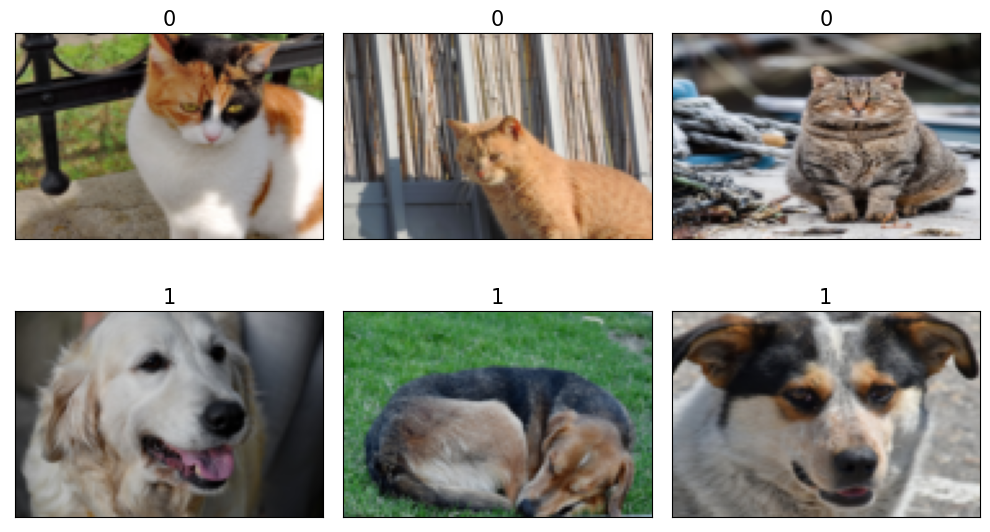

In [50]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
counter = 0

for i in range(2):
    for j in range(3):
        ax[i,j].set_xticks([]);ax[i,j].set_yticks([]);
        ax[i,j].imshow(image_dataset[counter][0].numpy().transpose((1,2,0)))
        ax[i,j].set_title(f'{image_dataset[counter][1]}',size=15)
        counter+=1
plt.tight_layout()
plt.show()

Further investigating PIL, and torchvision transforms and how they handle shapes

In [51]:
file_list[0]

'C:\\Users\\blais\\Documents\\ML\\data\\cat_dog_images\\cat-01.jpg'

In [52]:
im = Image.open(file_list[0])

In [56]:
im_arr = np.array(im)

In [57]:
im_arr.shape

(900, 1200, 3)

So, PIL data when converted to a numpy array gives you an image of the shape: HxWxC - height x width x channels

How about when we apply torch vision transformations to this data:

In [59]:
z = transforms.ToTensor()

In [61]:
y = z(im)

In [63]:
y.shape

torch.Size([3, 900, 1200])

the ToTensor transform transforms the PIL image - and returns an output of shape CxHxW

Back to the main book's flow:
- The __getitem__ method in the ImageDataset class wraps all four steps into a single function, including the loading of the raw content (images and labels), decoding the images into tensors, and resizing the images. The function then returns a dataset that we can iterate over and apply other operations learned in previous sections via a data loader, such as shuffling and batching.

**Fetching available datasets from the torchvision.datasets library:**
- First, we use the CelebA dataset:


In [64]:
import torchvision

In [78]:
img_path =r'C:\Users\blais\Documents\ML\data\celeb_a_dataset'

In [79]:
celeba_dataset = torchvision.datasets.CelebA(
    img_path, split='train',target_type='attr',download=False
)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [77]:
[str(path) for path in pathlib.Path(img_path).glob('*.jpg')]

[]